# NHW 2017. Two common pitfalls in designing of validation pipelines
Mikhail Belyaev

## Feature selection 

### There are three main groups of feature selection methods:
 - filters
 - wrappers
 - embedded methods 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
% pylab inline

Populating the interactive namespace from numpy and matplotlib


## Filters

- estimate an importance score for each feature
- select K most important one
- there are a lot of different ways to calculate feature importances
- Example: http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection 

### Example 1. Good classification performance, but low statistical score

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

Generate a simple dataset

In [3]:
def get_dataset1():
    X = np.random.rand(200, 2)
    X[:100, 0] += 1
    X[100:150, 0] += 2
    X[100:, 1] += 0.1
    y = np.concatenate([np.zeros(100), np.ones(100)])
    return X, y

X, y = get_dataset1()

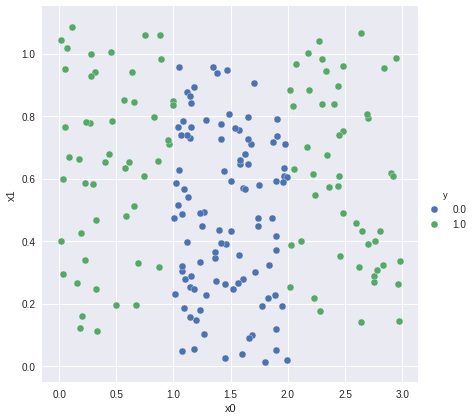

In [4]:
def plot_data(X, y):
    x_cols = ['x{}'.format(i) for i in range(X.shape[1])]
    df = pd.DataFrame(np.hstack((X, y[:, np.newaxis])), columns=x_cols+['y'])
    if len(x_cols) == 2:
        sns.pairplot(df, hue='y', x_vars='x0', y_vars='x1', size=6)
    else:
        sns.pairplot(df, hue='y', vars=x_cols)
plot_data(X, y)

In [5]:
# ANOVA
selector = SelectKBest(f_classif, 1)
selector.fit(X, y)
# SelectKBest just selects the specified number of features with the highest scores 
print(X.shape)
X_reduced = selector.transform(X)
print(X_reduced.shape)
# and what about scores?
print(selector.scores_)
# it selects the wrong variable!

(200, 2)
(200, 1)
[  6.26180513e-04   1.41367661e+01]


In [6]:
# mutial information is another way to estimate scores ...
selector = SelectKBest(mutual_info_classif, 1)
selector.fit(X, y)
print(selector.scores_)
# and it works in that case

[ 0.67493319  0.01317471]


### Example 2. Univariate stats doesn't catch bivariate dependencies

In [7]:
def get_dataset2(shift=0.2):
    X = np.random.rand(1000, 3)
    X = X[np.abs(X[:, 1] - X[:, 0]) < 0.22]
    X = X[np.abs(X[:, 1] - X[:, 0]) > 0.02]
    y = X[:, 1] > X[:, 0] 
    X[y, 2] += shift
    return X, y
X, y = get_dataset2()

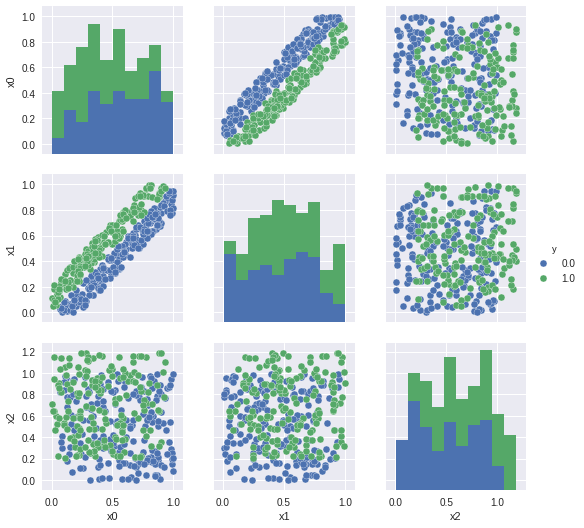

In [8]:
plot_data(X, y)

In [9]:
print(SelectKBest(f_classif, 2).fit(X, y).scores_)
print(SelectKBest(mutual_info_classif, 2).fit(X, y).scores_)
# both univariate methods fail

[ 33.53171036   9.12118776  41.79807046]
[ 0.05402509  0.0229263   0.13574176]


##  Wrappers
 - a greedy alrogithm for feature adding and/or deletion
 - there are a lot of different stratigies (starting points, criteria, etc)
 - an example http://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination 

In [10]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear")
rfe = RFE(estimator=svc, n_features_to_select=2, step=1)

In [11]:
rfe.fit(X, y)
print(rfe.ranking_)
# rank 1 means that these features were selected

[1 1 2]


## Embedded 
- features are selected automatically as a part of the learning process 
- an example - linear models with the L1 regularization

<div style="width:60%; text-align:center">
<img src=https://1.bp.blogspot.com/-tXq6Nl2lcNg/V3qzttiZ4sI/AAAAAAAAN_M/6nmjgwydWJUy5Kqt9gFg2Nb12BCTcD4ogCLcB/s1600/LASSO.png>
</div>

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', C=0.09)
clf.fit(X, y)
print(clf.coef_)

[[-0.72036396  0.          0.46270183]]


L1-penalty based approaches are a cool class of methods, but in case of correlated variables it can drop relevant features

Let us make the last component fully irrelevant and try a L1-based method again

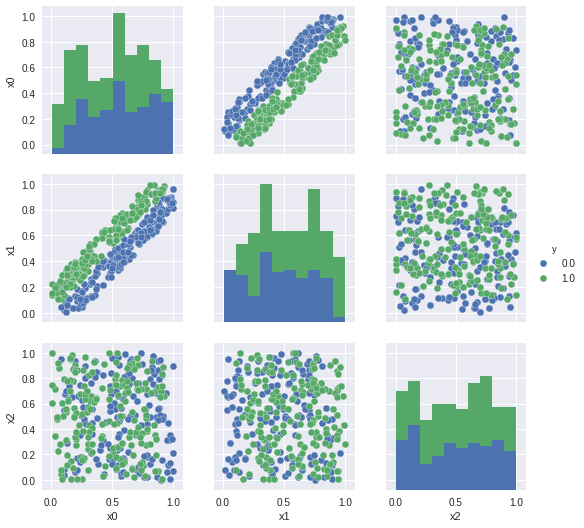

In [13]:
X, y = get_dataset2(shift=0)
df = pd.DataFrame(np.hstack((X, y[:, np.newaxis])), columns=['x0', 'x1', 'x2', 'y'])
sns.pairplot(df, hue='y', vars=['x0', 'x1', 'x2'])

In [14]:
clf = LogisticRegression(penalty='l1', C=0.2)
clf.fit(X, y)
print(clf.coef_)

[[-8.08741839  8.23614206  0.        ]]


### Feature selection: a small example

#### ~~TODO~~: 
 - ~~load an anonimized dataset from dataset3.csv~~
 - ~~estimate the 10 most important features (using f_classif)~~
 - ~~perform cross-validation & estimate classification quality~~

In [15]:
def get_dataset3():
    data = pd.read_csv('dataset3.csv')
    y = data['y']
    X = data.drop('y', axis=1)
    return X, y
X, y = get_dataset3()

In [16]:
# it's an anonimizd dataset with standatized features
print('Data shape is {}'.format(X.shape))
print('Class 0 size is {}'.format(sum(y==0)))
print('Class 1 size is {}'.format(sum(y==1)))
X.head(5)

Data shape is (121, 4873)
Class 0 size is 71
Class 1 size is 50


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x4863,x4864,x4865,x4866,x4867,x4868,x4869,x4870,x4871,x4872
0,0.415565,-0.144159,1.498688,0.843930,1.736326,-1.048023,-0.567444,-1.568540,-0.454729,-1.238958,...,-0.136349,0.664779,-0.361853,1.577162,1.197755,-1.635533,0.618030,0.560045,-1.120412,0.205123
1,0.759752,-1.270058,-0.463532,1.701806,0.199459,-1.055586,-0.611728,0.491234,0.212398,-0.831789,...,-0.926783,1.757657,0.607199,-0.993059,0.041725,1.751181,-1.324243,1.355293,-0.618517,-0.687989
2,0.575741,0.569141,0.232469,1.312427,1.105427,0.405529,-1.508660,-0.951836,0.365138,-0.743987,...,0.050227,1.539508,0.262433,0.785780,-0.615320,1.104032,-1.561042,0.448165,-1.010801,1.659146
3,-0.409274,0.632820,0.421591,0.540943,-0.669616,-0.047474,1.758110,-1.602530,2.352296,-0.344142,...,-0.104558,-1.625126,-0.413647,-1.991743,-0.891705,-1.418683,-1.817538,-1.139779,-0.699888,1.597597
4,0.888073,-2.458116,-0.218338,0.346368,-0.262323,0.520068,-0.251153,1.320535,1.899126,0.906623,...,0.857870,-1.730599,-1.181402,0.322079,-0.329885,-0.443631,0.187749,1.590329,1.855634,-1.824229


#### The number of features is too large, so it seems to be a good idea to start with feature selection

In [17]:
n_features = 50
selector = SelectKBest(f_classif, n_features)
X_reduced = selector.fit_transform(X, y)
print('The new shape is {}'.format(X_reduced.shape))

The new shape is (121, 50)


#### Now we have a reasonable number of features and can estimate classification accuracy 

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()
scores = cross_val_score(clf, X_reduced, y, scoring='accuracy', cv=5)
print(scores)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))

[ 0.96        0.95833333  0.95833333  1.          1.        ]
Accuracy of classification is 0.98 +- 0.02


In [19]:
# what if we skip the feature selection step?
clf = LogisticRegressionCV()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
print('Accuracy of a naive classifier is {}'.format((y==0).mean()))

Accuracy of classification is 0.55 +- 0.05
Accuracy of a naive classifier is 0.5867768595041323


#### So, we've obtained a great result using feature selection! Probably, too good to be true ...

Sanity check: randomly shuffle labels

In [20]:
y_random = y.copy() 
np.random.shuffle(y_random)

In [21]:
X_reduced = selector.fit_transform(X, y_random)
scores = cross_val_score(clf, X_reduced, y_random, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))

Accuracy of classification is 0.94 +- 0.02


#### There is a mistake somewhere ...

#### We used *all* available data for feature selection!

### How to do a multistep analysis in a correct way? Use pipeline!

In [22]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(SelectKBest(f_classif, n_features), 
                      LogisticRegressionCV())
scores = cross_val_score(pipe, X, y_random, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))

scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))

Accuracy of classification is 0.59 +- 0.06
Accuracy of classification is 0.60 +- 0.02


## Selection of hyperparameters & grid search 

In [23]:
def f_poly(x, coefs):
    summands = [x**(power+1) * coef for power, coef in enumerate(coefs)]
    return np.array(summands).sum(0)

def get_function(coefs=None):
    if coefs is None:
        coefs = [1, -0.5, -1, 0.6]
    return lambda x: f_poly(x, coefs)

def get_dataset4(f, sample_size, noise_std=0.1):
    X = np.random.rand(sample_size, 1) * 2 - 1
    y = f(X)
    y += np.random.randn(*y.shape) * noise_std
    return X, y

def plot_dataset4(f, X=None, y=None, regr=None):
    X_plot = np.linspace(-1, 1, 100)[:, np.newaxis]
    plt.plot(X_plot, f(X_plot), label='True function')
    if X is not None and y is not None:
        plt.plot(X, y, '.r')
    if regr is not None:
        plt.plot(X_plot, regr.predict(X_plot), label='Prediction')
    plt.legend(loc='best')
    plt.ylim([-0.8, 0.6])

#### Lets generate a dataset

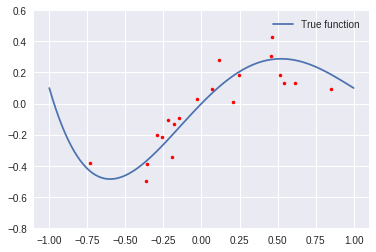

In [24]:
f = get_function()
X, y = get_dataset4(f, 20)
X_test, y_test = get_dataset4(f, 100)
plot_dataset4(f, X, y)

#### We'll use a polinomial model to fit the data and ridge regression to estimate coefficients of the model

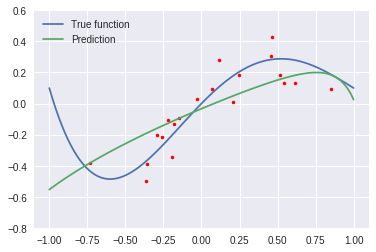

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
regr = make_pipeline(PolynomialFeatures(20), Ridge())
regr.fit(X, y)
plot_dataset4(f, X, y, regr)

In [26]:
from sklearn.metrics.regression import mean_squared_error as mse

def get_errors(regr, X, y):
    y_predicted = regr.predict(X)
    mse(y, y_predicted)**0.5
    return mse(y, y_predicted)**0.5
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))

Root mean squared error is 0.1873931585694121


### Bias-variance tradeoff

<div style="width:100%; text-align:center">
<img src=http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png width=500px>
</div>
from a great tutorial http://scott.fortmann-roe.com/docs/BiasVariance.html

### We can use regularization to control model parameters

Root mean squared error is 189.2256443406622


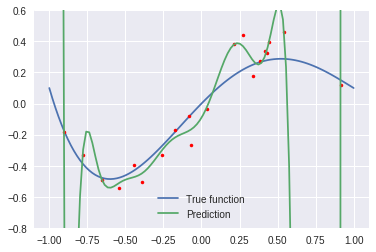

In [27]:
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(1e-9))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

Root mean squared error is 0.2949936379736308


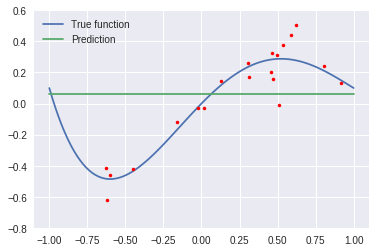

In [28]:
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(1e9))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

Root mean squared error is 0.11014190278143486


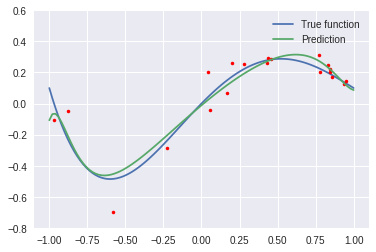

In [29]:
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(0.1))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

#### So, quality depends on regularization parameter significantly 

### How to select model parameters?

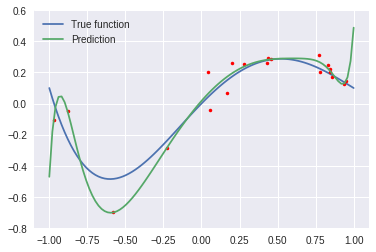

In [30]:
from sklearn.model_selection import GridSearchCV
# our model is a pipeline, so we have to use a special format to specify parameters
# 
parameters = {'ridge__alpha':10**np.linspace(-5, 5, 21)}
regr = make_pipeline(PolynomialFeatures(20), Ridge())
regr_grid = GridSearchCV(regr, parameters)
regr_grid.fit(X, y)

plot_dataset4(f, X, y, regr_grid)

### But what is we have more than one parameter to adjust?

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
parameters = {'learning_rate': [0.001, 0.005, 0.01, 0.025, 0.05, 0.1],
              'max_depth': range(1, 10),
              'n_estimators': [5, 10, 20, 35, 50, 100],
             }
clf_grid = GridSearchCV(clf, parameters, n_jobs=-1, verbose=True)
X, y = get_dataset3()
clf_grid.fit(X, y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 11.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.025, 0.05, 0.1], 'max_depth': range(1, 10), 'n_estimators': [5, 10, 20, 35, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [52]:
best_score_ = clf_grid.best_score_
best_params = clf_grid.best_params_

### An error with a fixed parameters is a random variable

Root mean squared error is 0.11733688332146874


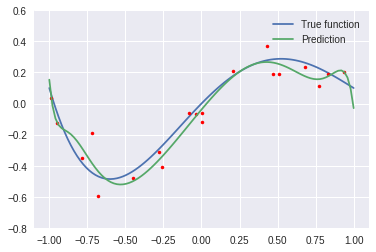

In [35]:
# execute this cell multiple times and track function's behavior and the error
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(1e-4))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

### We can plot distribution of erros

#### for a single model ...

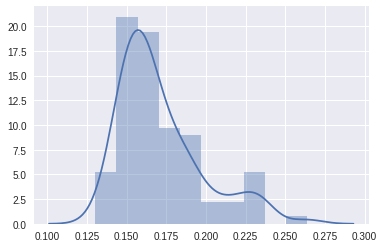

In [36]:
def get_scores(regr, sample_size, n_repeats):
    scores = []
    for i in range(n_repeats):
        X, y = get_dataset4(f, sample_size)
        regr.fit(X, y)
        scores.append(get_errors(regr, X_test, y_test))
    return scores
regr = make_pipeline(PolynomialFeatures(20), Ridge())
scores = get_scores(regr, 20, 100)
sns.distplot(scores)

#### ... and for several model

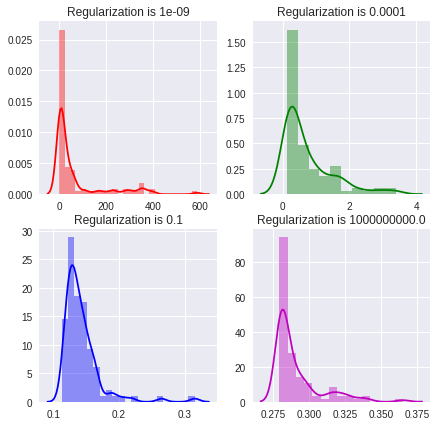

In [37]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
sns.despine(left=True)

def plot_hist(alpha, color, ax):
    regr = make_pipeline(PolynomialFeatures(20), Ridge(alpha=alpha))
    scores = get_scores(regr, 20, 100)
    sns.distplot(scores, color=color, ax=ax)
    ax.set_title('Regularization is {}'.format(alpha))

plot_hist(alpha=1e-9, color='r', ax=axes[0, 0])
plot_hist(alpha=1e-4, color='g', ax=axes[0, 1])
plot_hist(alpha=1e-1, color='b', ax=axes[1, 0])
plot_hist(alpha=1e9, color='m', ax=axes[1, 1])

### Now check the optimal parameters which were found by GridSearch

In [51]:
from sklearn.model_selection import KFold
scores = []
X, y = get_dataset3()
for i in range(100):
    clf = GradientBoostingClassifier(**best_params)
    cv = KFold(random_state=i, shuffle=True)
    score = cross_val_score(clf, X, y, cv=cv, n_jobs=-1).mean()
    scores.append(score)

0.595041322314


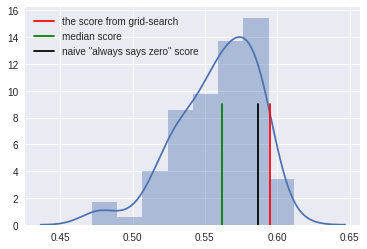

In [64]:
sns.distplot(scores)
# sns.distplot([best_score_]*100)
plt.plot([best_score_] * 10 , range(10), 'r', label='the score from grid-search')
plt.plot([np.median(scores)] * 10 , range(10), 'g', label='median score')
plt.plot([np.mean(y==0)] * 10 , range(10), 'k', label='naive "always says zero" score')
plt.legend()

### The problem is that GridSearchCV gives you a single number from the whole distribution. Due to a greedy nature of the algorithm, this score is usually too optimistic

## Take-away messages

 - Ideally, use an independent test set 
 - If you use multistep anysis always chain these steps into a single sklearn pipeline
 - As a sanity check, you can feed to your analysis random variables and compare the obrained results with the expected quality of random classification
 - Do not trust GridSearchCV results, always re-check the optimal comination of parameters